In [38]:
# Import Library
%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

# Prepare and Review Dataset

In [39]:
# Test and Train path
with open('newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Costruisco le immagini

[ 373.4    0.  5764.5   77.2   72.  7891.4 5227.  5149.8 6322.4 6056.8]


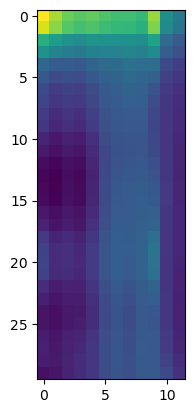

In [40]:
# Test and Train path
train_path = "dataset\\train\\"
test_path = "dataset\\test\\"

max = allPixel3.max()
min = allPixel3.min()
training_set = []
test_set = []
choice = np.random.choice(range(allPixel3.shape[0]), size=(790,), replace=False)
ind = np.zeros(allPixel3.shape[0], dtype=bool)
ind[choice] = True
rest = ~ind
training_setX = allPixel3[ind,:,:]
training_setY = newResa3[ind]
training_setX = np.array(training_setX)
training_setY = np.array(training_setY)

test_setX = allPixel3[rest,:,:]
test_setY = newResa3[rest]
test_setX = np.array(test_setX)
test_setY = np.array(test_setY)

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))

#Train Set
for a in range(0,training_setX.shape[0]):
    img = Image.fromarray(training_setX[a,:,:])
    img.save(train_path+str(a)+'.tiff')

#Test Set
for a in range(0,test_setX.shape[0]):
    img = Image.fromarray(test_setX[a,:,:])
    img.save(test_path+str(a)+'.tiff')


In [41]:


# Costruiamo un dataframe Train
dFTrain = pd.DataFrame(columns=['id','target'])
dFTrain['id'] = [str(x)+".tiff" for x in list(range(0,training_setX.shape[0]))]
dFTrain['target'] = training_setY/training_setY.max()
print(dFTrain.head())

# Costruiamo un dataframe Test
dFTest = pd.DataFrame(columns=['id','target'])
dFTest['id'] = [str(x)+".tiff" for x in list(range(0,test_setX.shape[0]))]
dFTest['target'] = test_setY/test_setY.max()

# Prepare the dataset
#Train dataset
train_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTrain, target_size = (32,32),
                                                      directory=train_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

#Test Dataset
test_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTest, target_size = (32,32),
                                                      directory=test_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

       id    target
0  0.tiff  0.122000
1  1.tiff  0.201148
2  2.tiff  0.198501
3  3.tiff  0.196035
4  4.tiff  0.003445
Found 790 validated image filenames.
Found 789 validated image filenames.


# Creazione del modello di Vgg16

In [42]:
# Import model
vgg16 = VGG16(input_shape=(32,32,3),include_top=False)

# Import model
#vgg16 = VGG16()

In [43]:
# layers of vgg16
vgg16_layer_list = vgg16.layers
for i in vgg16_layer_list:
    print(i)

In [44]:
# add the layers of vgg16 in my created model.
vgg16Model = Sequential()
for i in range(len(vgg16_layer_list)-1):
    vgg16Model.add(vgg16_layer_list[i])

In [45]:
# Close the layers of vgg16
for layers in vgg16Model.layers:
    layers.trainable = False

In [46]:
# Last layer
#vgg16Model.add(Dense(units=1))

vgg16Model.add(Dense(units=1))

In [47]:
# After I added last layer in created model.
vgg16Model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [48]:
# I create compile part.
vgg16Model.compile(loss = "mean_squared_error",
             optimizer = "rmsprop",
             metrics = ["mse","mae","accuracy"])

# Training Model 

In [49]:
# Traning with model
batch_size = 32

hist_vgg16 = vgg16Model.fit(train_data, 
                                epochs = 10,
                                validation_data=test_data
                                )

Epoch 1/10
25/25 [==============================] - 5s 176ms/step - loss: 0.0229 - mse: 0.0229 - mae: 0.1010 - accuracy: 0.0139 - val_loss: 0.0123 - val_mse: 0.0123 - val_mae: 0.0740 - val_accuracy: 0.0089
Epoch 2/10
25/25 [==============================] - 4s 160ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0750 - accuracy: 0.0139 - val_loss: 0.0101 - val_mse: 0.0101 - val_mae: 0.0612 - val_accuracy: 0.0089
Epoch 3/10
25/25 [==============================] - 4s 157ms/step - loss: 0.0160 - mse: 0.0160 - mae: 0.0730 - accuracy: 0.0139 - val_loss: 0.0148 - val_mse: 0.0148 - val_mae: 0.0885 - val_accuracy: 0.0089
Epoch 4/10
25/25 [==============================] - 4s 157ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0716 - accuracy: 0.0139 - val_loss: 0.0114 - val_mse: 0.0114 - val_mae: 0.0690 - val_accuracy: 0.0089
Epoch 5/10
25/25 [==============================] - 4s 156ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0694 - accuracy: 0.0139 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 

In [50]:
# Save the weights of model
vgg16Model.save_weights("previsioneResa.h5")

# Andiamo a visualizzare i risultati della rete

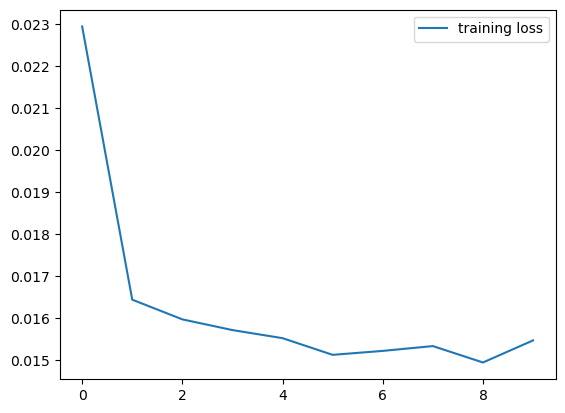

In [51]:
# Loss and Validation Loss
plt.plot(hist_vgg16.history["loss"], label = "training loss")
#plt.plot(hist_vgg16.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

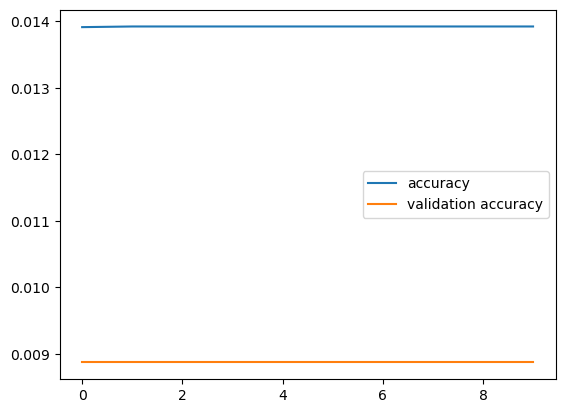

In [52]:
# Accuracy and Validation Accuracy
plt.plot(hist_vgg16.history["accuracy"], label = "accuracy")
plt.plot(hist_vgg16.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.show()

# Salviamo e carichiamo i risultati

In [53]:
import json, codecs
with open("deneme.json","w") as f:
    json.dump(hist_vgg16.history, f)

In [54]:
with codecs.open("./deneme.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())

In [55]:
load_result

{'loss': [0.022938000038266182,
  0.01644052192568779,
  0.01597210206091404,
  0.01571747660636902,
  0.015525237657129765,
  0.015128458850085735,
  0.015222406014800072,
  0.015336986631155014,
  0.014946887269616127,
  0.015471967868506908],
 'mse': [0.022938000038266182,
  0.01644052192568779,
  0.01597210206091404,
  0.01571747660636902,
  0.015525237657129765,
  0.015128458850085735,
  0.015222406014800072,
  0.015336986631155014,
  0.014946887269616127,
  0.015471967868506908],
 'mae': [0.10096035897731781,
  0.07502230256795883,
  0.07301010191440582,
  0.07164958119392395,
  0.06939570605754852,
  0.06705830991268158,
  0.06942993402481079,
  0.06868299096822739,
  0.06776731461286545,
  0.06736220419406891],
 'accuracy': [0.01391416136175394,
  0.013924051076173782,
  0.013924051076173782,
  0.013924051076173782,
  0.013924051076173782,
  0.013924051076173782,
  0.013924051076173782,
  0.013924051076173782,
  0.013924051076173782,
  0.013924051076173782],
 'val_loss': [0.012

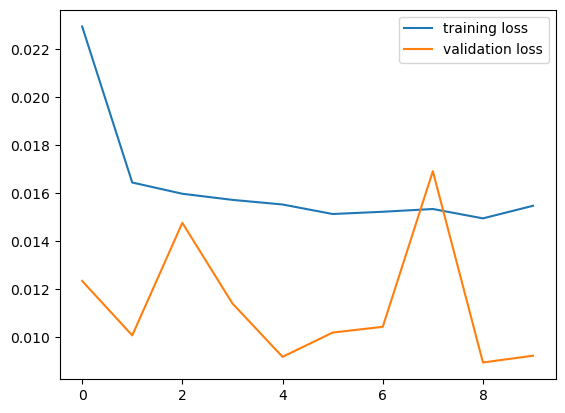

In [56]:
# Loss And Validation Loss
plt.plot(load_result["loss"], label = "training loss")
plt.plot(load_result["val_loss"], label = "validation loss")
plt.legend()
plt.show()

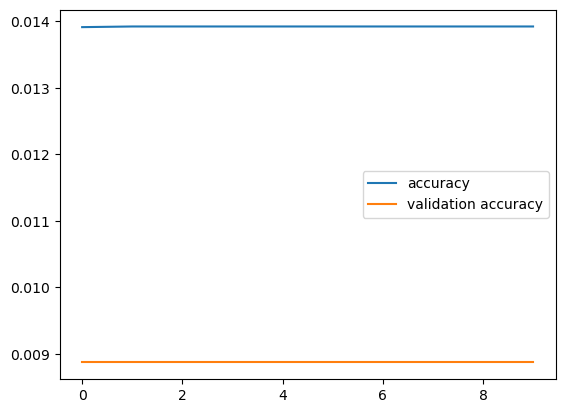

In [57]:
plt.plot(load_result["accuracy"], label = "accuracy")
plt.plot(load_result["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.show()

# Vgg19

In [58]:
# Import VGG19 model
vgg19 = VGG19()

574710816/574710816 [==============================] - 26s 0us/step


In [59]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [60]:
# Layers of vgg19 
vgg19_layer_list = vgg19.layers
for i in vgg19_layer_list:
    print(i)

In [61]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
for i in range(len(vgg19_layer_list)-1):
    vgg19Model.add(vgg19_layer_list[i])

In [62]:
# Finish version of my created model.
vgg19Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [63]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [64]:
# Last layer
vgg19Model.add(Dense(numberOfClass, activation = "softmax"))

NameError: name 'numberOfClass' is not defined

In [ ]:
# the final version of the model
vgg19Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
# I create compile part.
vgg19Model.compile(loss = "categorical_crossentropy",
             optimizer = "rmsprop",
             metrics = ["accuracy"])

# Addestramento

In [ ]:
# Traning with model
batch_size = 32

# Training with my created model
hisy_vgg19 = vgg19Model.fit_generator(train_data,
                               steps_per_epoch = 1600 // batch_size,
                               epochs = 10,
                               validation_data = test_data,
                               validation_steps = 800 // batch_size)

Epoch 1/10
50/50 [==============================] - 700s 14s/step - loss: 0.6683 - accuracy: 0.7713 - val_loss: 0.4304 - val_accuracy: 0.8600
Epoch 2/10
50/50 [==============================] - 622s 12s/step - loss: 0.4122 - accuracy: 0.8581 - val_loss: 0.4579 - val_accuracy: 0.8550
Epoch 3/10
50/50 [==============================] - 313s 6s/step - loss: 0.4227 - accuracy: 0.8588 - val_loss: 0.4613 - val_accuracy: 0.8462
Epoch 4/10
50/50 [==============================] - 317s 6s/step - loss: 0.3969 - accuracy: 0.8744 - val_loss: 0.4060 - val_accuracy: 0.8687
Epoch 5/10
50/50 [==============================] - 395s 8s/step - loss: 0.3667 - accuracy: 0.8856 - val_loss: 0.5224 - val_accuracy: 0.8388
Epoch 6/10
50/50 [==============================] - 319s 6s/step - loss: 0.3512 - accuracy: 0.8794 - val_loss: 0.4440 - val_accuracy: 0.8625
Epoch 7/10
50/50 [==============================] - 318s 6s/step - loss: 0.3539 - accuracy: 0.8850 - val_loss: 0.4862 - val_accuracy: 0.8575
Epoch 8/10


# Visualizziamo i risultati ottenuti

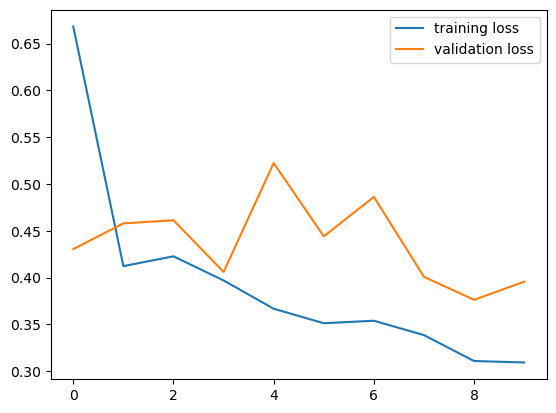

In [ ]:
# Loss And Validation Loss
plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

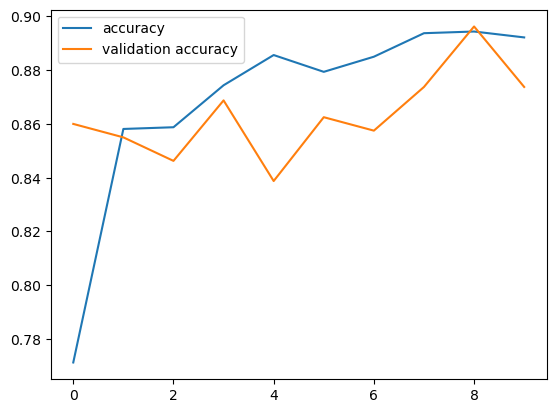

In [ ]:
# Accuracy And Validation Accuracy
plt.plot(hisy_vgg19.history["accuracy"], label = "accuracy")
plt.plot(hisy_vgg19.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.show()